In [1]:
from mmapdict import MMapDict

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk

import pickle
import shutil
import os
import glob

from retry import retry

import functools

In [2]:
def function_name(func):
    """関数に一意な名前を付ける"""
    if hasattr(func, "__self__"):
        # クラスメソッドのとき
        # クラス名.関数名　を返す
        class_name = func.__self__.__class__.__name__
        return f"{class_name}.{func.__name__}"
    else:
        # クラスメソッドでないとき
        return func.__name__

In [3]:
from utils import time_manager
import threading
from concurrent.futures import ThreadPoolExecutor

class Scheduler:
    def __init__(self, tasks=[], interval_sec=1, max_workers=10):
        self.tasks = tasks
        self.interval_sec = interval_sec
        self.max_workers = max_workers
        self.should_stop = False
        self.thread = threading.Thread(target=self.schedule)
        
    def __del__(self):
        self.stop()
        
    def exec_all_tasks(self):
        for task in self.tasks:
            task()
        
    def schedule(self):
        """任意の処理を定期的に実行する"""
        
        # 必要以上にスレッドが生成されないようにスレッドプールを使う
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            while not self.should_stop:
                time_manager.wait_if_pace_too_fast(self.interval_sec)
                future = executor.submit(self.exec_all_tasks)
    
    def register(self, task):
        self.tasks.append(task)
    
    def start(self):
        self.thread.start()
    
    def stop(self):
        self.should_stop = True

In [4]:
class SelfMimic:
    def __init__(self, savedir):
        """他のプロセスの特定のオブジェクトのようにふるまう"""
        self._dict = MMapDict(savedir)
        
    def __getattr__(self, name):
        if 'button' not in self._dict:
            return None
        else:
            return self._dict[name]

class TkParams:
    def __init__(self, savedir='./tk_params/', gui_process=True, instance=None):
        self.savedir = savedir
        self.gui_process = gui_process
        if not gui_process:
            if os.path.exists(savedir):
                shutil.rmtree(savedir)
            os.makedirs(savedir)
            os.makedirs(f"{savedir}widgets/")
        
        self.widgets = {
            "slider": MMapDict(f"{savedir}widgets/slider/"),
            "toggle_button": MMapDict(f"{savedir}widgets/toggle_button/"),
            "button": MMapDict(f"{savedir}widgets/button/"),
        }
        
        self.sliders = MMapDict(f"{savedir}slider/")
        self.toggle_buttons = MMapDict(f"{savedir}toggle_button/")
        self.buttons = MMapDict(f"{savedir}button/")
        
        self.mimic = SelfMimic(f"{savedir}self/")
        
        if not gui_process:
            self.instance = instance
            
            self.observer = Scheduler(interval_sec=0.1)
            self.observer.start()
        
    def __del__(self):
        self.observer.stop()
        
    def give_mimic_info(self):
        for key in self.mimic._dict.keys():
            self.mimic[key] = getattr(self.instance, key)
        
    def get_float(self, key, from_=0, to=1, resolution=None, default=None):
        if key in self.sliders:
            # GUIにすでにウィジェットがあったら
            return float(self.sliders[key])
        else:
            # GUIにまだウィジェットがなかったら
            # ウィジェットを追加するよう伝えつつ、今回はデフォルト値を返す
            self.widgets["slider"][key] = {
                'name': key,
                'from_': from_,
                'to': to,
                'resolution': resolution,
                'default': default,
            }
            return from_ if default is None else default
        
    def get_bool(self, key, default=None):
        if key in self.toggle_buttons:
            return bool(self.toggle_buttons[key])
        else:
            self.widgets["toggle_button"][key] = {
                'name': key,
            }
            return False if default is None else default
        
    def _called(self, key):
        try:
            has_called = bool(self.buttons[key])
            self.buttons[key] = False
        except KeyError:
            has_called = False
        return has_called
        
    def button(self, func):
        # ボタンが押されたことを検知した時点で関数を実行するよう登録する
        assert not self.gui_process
        key = function_name(func)
        self.widgets["button"][key] = {
            'name': key,
        }
        def exec_if_called():
            if self._called(key):
                func()
        self.observer.register(exec_if_called)

In [5]:
class Application(tk.Tk):
    def __init__(self, title='GUI App', dt=100):
        super().__init__()
        self.title(title)
        
        # 画面をグラフを配置する場所とボタン等を配置する場所に分ける
        self.canvas_frame = tk.Frame(self)
        self.canvas_frame.pack(side=tk.LEFT)
        self.control_frame = tk.Frame(self)
        self.control_frame.pack(side=tk.RIGHT)
        
        #self.figures = {}
        self.sliders = {}
        self.toggle_buttons = {}
        self.buttons = {}
        
        # TODO: 配布しても問題ない画像を作成してgithubにあげる
        self.on_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_on_transparent.png").subsample(5)
        self.off_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_off_transparent.png").subsample(5)
        
        self.tkparams = TkParams()
        
        self.dt = dt
        self.update_widget()

    def add_figure(self, name, init_anim, update_anim):
        #self.figures[name] = Figure(self, name, init_anim, update_anim)
        init_anim_with_self = lambda : init_anim(self.tkparams.mimic)
        update_anim_with_self = lambda : update_anim(self.tkparams.mimic)
        self.figure = Figure(self, name, init_anim_with_self, update_anim_with_self)
        
    def add_slider(self, name, from_=0, to=1, resolution=None, default=None):
        self.sliders[name] = Slider(self, name, from_, to, resolution, default)
        
    def add_toggle_button(self, name):
        self.toggle_buttons[name] = ToggleButton(self, name, self.on_image, self.off_image)
        
    def add_button(self, name):
        self.buttons[name] = Button(self, name)
    
    def update_widget(self):
        slider_params = self.tkparams.widgets["slider"]
        for name in (set(slider_params) - set(self.sliders)): # まだ追加していないスライダーについてループ
            self.add_slider(**slider_params[name])
            
        toggle_button_params = self.tkparams.widgets["toggle_button"]
        for name in (set(toggle_button_params) - set(self.toggle_buttons)):
            self.add_toggle_button(**toggle_button_params[name])
            
        button_params = self.tkparams.widgets["button"]
        for name in (set(button_params) - set(self.buttons)):
            self.add_button(**button_params[name])
            
        # dt[ms]後にこの関数自身を呼び出す
        self.after(self.dt, self.update_widget)

class Figure:
    def __init__(self, app, name, init_anim, update_anim):
        self.app = app
        self.name = name
        
        self.fig = plt.figure(figsize=(5, 5))
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, self.app.canvas_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.init_anim = lambda : init_anim(self.ax)
        self.update_anim = update_anim
        
        self.ani = None
        self.draw_plot()
        
    def draw_plot(self, event=None):
           # すでにアニメーションが実行されている場合はevent_source.stopで停止
        if self.ani is not None:
            self.ani.event_source.stop()
            self.ax.clear()

        self.ani = FuncAnimation(
              self.fig,  # Figureオブジェクト
              self.update_anim,  # グラフ更新関数
              init_func=self.init_anim,  # 初期化関数
              interval = self.app.dt,  # 更新間隔(ms)
              blit = True,
        )
        self.canvas.draw()
        
class Widget:
    def __init__(self, app, name):
        self.app = app
        self.name = name
        
        # 枠の作成
        self.frame = tk.Frame(app.control_frame, bd=1, relief=tk.SUNKEN)
        self.frame.pack(fill=tk.X)
    
        # 説明テキストの作成
        self.control_label = tk.Label(self.frame, text=self.name)
        self.control_label.pack(side='left')
        
        
class Slider(Widget):
    def __init__(self, app, name, from_=0, to=1, resolution=None, default=None):
        super().__init__(app, name)
        
        self.app.tkparams.sliders[self.name] = from_ if default is None else default
    
        self.var = tk.DoubleVar()
        self.x_scale = tk.Scale(
            self.frame,
            variable=self.var,
            from_=from_,
            to=to,
            resolution=(to - from_) * 0.01 if resolution is None else resolution,
            orient=tk.HORIZONTAL,
            command=self.on_change,
        )
        self.x_scale.pack(anchor=tk.E)
        
    def on_change(self, event=None):
        self.app.tkparams.sliders[self.name] = self.var.get()
        
class ToggleButton(Widget):
    def __init__(self, app, name, on_image, off_image):
        super().__init__(app, name)
        self.on_image = on_image
        self.off_image = off_image
        self.is_on = False
        
        self.button = tk.Button(
            self.frame, 
            image = off_image, 
            relief='sunken', 
            bd = 0, 
            command = self.switch
        )
        self.button.pack(anchor=tk.E)
    
    def switch(self):
        if self.is_on:
            self.button.config(image = self.off_image)
            self.is_on = False
            self.app.tkparams.toggle_buttons[self.name] = False
        else:
            self.button.config(image = self.on_image)
            self.is_on = True
            self.app.tkparams.toggle_buttons[self.name] = True
            
class Button(Widget):
    def __init__(self, app, name):
        super().__init__(app, name)
        
        self.button = tk.Button(
            self.frame, 
            text=self.name,
            command = self.press
        )
        self.button.pack(anchor=tk.E)
    
    def press(self):
        self.app.tkparams.buttons[self.name] = True

In [7]:

class Furiko:
    def __init__(self):
        self.reset()
        self.theta_0 = np.pi / 4 # 初期の角度
        self.marker_size = 12
        self.tkparams = TkParams(gui_process=False, instance=self)
        self.tkparams.button(self.random)
        
    def random(self):
        self.im.set_color(np.random.rand(3,))
        
    def reset(self):
        bpm = self.tkparams.get_float('bpm', 30, 200, 1)
        self.g = 1.62 if self.tkparams.get_bool("apply lunar gravity") else 9.8   # 重力加速度
        self.T = round(1 / (bpm / 60), 2) # BPを取得し、周期の計算
        self.l = (self.T ** 2) * self.g / (4 * np.pi ** 2)  # 振り子の長さを計算
        self.omega = np.sqrt(self.g / self.l)  # 角速度
        
    def init_anim(self, ax):
        '''アニメーション初期化用の関数'''
        ax.set_xlim(-1.2,1.2)
        ax.set_ylim(-1.2,1.2)
        self.im, = ax.plot([], [], color='k', marker='o', markersize=int(self.marker_size), linestyle='None')
        self.line, = ax.plot([], [], color='k')
        
        return self.im, self.line

    def update_anim(self, dt):
        '''グラフ更新関数'''
        self.reset()
        
        self.theta = self.theta_0 * np.cos(self.omega * dt / 20)
        x = self.l * np.sin(self.theta)
        y = - self.l * np.cos(self.theta)
        self.im.set_data(x, y)
        self.line.set_data([0, np.sin(self.theta)], [0, -np.cos(self.theta)])
        return self.im, self.line

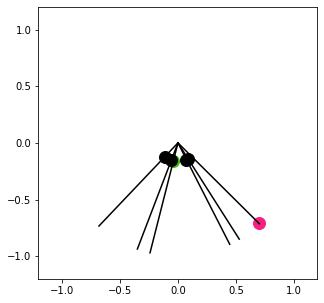

In [7]:
app = Application(dt=50)
furiko = Furiko()
app.add_figure('furiko', furiko.init_anim, furiko.update_anim)
app.mainloop()

In [7]:
mm = MMapDict('./tk_params/self/')

SyntaxError: invalid syntax (Temp/ipykernel_1124/2598888547.py, line 6)

In [13]:
import glob

In [18]:
path = glob.glob(savedir+'*')[0]
filename = path.replace('\\', '/').removeprefix(savedir)
key = '.'.join(filename.split('.')[:-1])

In [1]:
from kabusapi import KabuStationAPI

In [35]:
KabuStationAPI(account_type='corporation')

'0'

In [26]:
r'./temp\\'

'./temp\\\\'

In [9]:
%debug

> c:\users\kose\onedrive\ドキュメント\github\autoguigenerator\src\guigen\mmapdict.py(85)__getitem__()
     83             value = self.mmaps[key].read()
     84         except pickle.UnpicklingError as e:
---> 85             raise KeyError(key) from e
     86 
     87         return value

ipdb> key
0
ipdb> ll
     78     def __getitem__(self, key):
     79         if key not in self.mmaps:
     80             self.mmaps[key] = ObjectStream(self._key2path(key))
     81 
     82         try:
     83             value = self.mmaps[key].read()
     84         except pickle.UnpicklingError as e:
---> 85             raise KeyError(key) from e
     86 
     87         return value
     88 

ipdb> value
*** NameError: name 'value' is not defined
ipdb> a
self = <mmapdict.MMapDict object at 0x00000203B7F4C910>
key = 0
ipdb> u
> c:\users\kose\appdata\local\temp\ipykernel_9324\742912053.py(1)<module>()

ipdb> l
----> 1 3 in temp

ipdb> q


In [15]:
bytes(' '*100, encoding='utf-8')

b'                                                                                                    '

In [4]:
temp = ObjectStream('./mmap.txt')

In [9]:
temp.write(np.arange(100))

In [10]:
temp.read()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [17]:
len(mm)

256

In [39]:
mm.close()

In [28]:
mm

<mmap.mmap closed=False, access=ACCESS_DEFAULT, length=256, pos=149, offset=0>

In [26]:
mm[:1]

b'0'